In [ ]:
# landau-simulation-analysis.ipynb
#
# Bryan Daniels
# 2021/9/3
# 2023/4/10 renamed
#
# Analysis of Landau procedure applied to test simulation data.
#
# Combining code from compare-landau-and-gaussian.ipynb, test-landau.ipynb
#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from landauAnalysis import landauAnalysis,principalComponents,gaussianMixtureAnalysis
from landauAnalysis import LandauTransitionDistributionRelativeLogPDF
from runFittingAnalysis import loadBeeData

from toolbox import setDefaultParams,makePretty,load
setDefaultParams()

In [35]:
def bistablePlot(finalStates,vec,Jvals,Jvecs,c,d,nuMu,returnData=False,plotTheory=True,plotGaussian=True,bins=30,
                xScale=1.,**histKwargs):
    
    # calculate projection along eigenvector
    
    if (len(vec) == 1) and (finalStates.shape[1] > 1):
        # compute principal eigenvector manually if we're given a vec from a projected analysis
        PCAvals,PCAvecs = principalComponents(finalStates)
        projVec = PCAvecs[0]
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = np.mean(x)
    else:
        projVec = vec
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = sampleMean
    
    
    # plot histogram of data
    plt.hist(x,density=True,bins=bins,**histKwargs)

    if plotTheory:
        # plot inferred relative log-likelihood
        xRange = 1.5*xScale*(x.max() - x.min())
        print('xRange = {}'.format(xRange))
        plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,xRange=xRange)
        
    if plotGaussian:
        # compare to Gaussian null model
        xVals = np.linspace(-xRange/2.,xRange/2.,500)
        distGaussian = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                            meanFinalState + xVal*vec,   
                            meanFinalState,
                            Jvals,
                            Jvecs,
                            vec,
                            1.,
                            0.)) for xVal in xVals ]
        distGaussian = distGaussian / (np.sum(distGaussian)*(np.diff(xVals)[0]))
        plt.plot(xVals,distGaussian,lw=2,color='black',label='Gaussian mixture fit')

    plt.xlabel('Gene expression\nalong bistable dimension')
    plt.ylabel('Probability')

    if returnData:
        return {'x': x,
                'vec': vec,
                'mu': mu,
                'runIndex': runIndex,
                'meanFinalState': meanFinalState,
                }

In [3]:
# bistablePlot code modified from test-landau.ipynb
def bistablePlot_fromDataDict(df,dataDict,runIndex,muIndex,returnData=False,offset=0,**kwargs):
    
    d = df
    dd = dataDict
    mu = d['mu'].unique()[muIndex]
    landauData = dd[(runIndex,offset)][mu]['landauAnalysis']
    
    dSeries = d[(d['runIndex']==runIndex) & (d['mu']==mu)]

    bistableIndex = int(dSeries['bistable index'].iloc[0])
    vec = np.real_if_close( landauData['vecList'][bistableIndex] )

    finalStates = dd[(runIndex,offset)][mu]['finalStates']
    
    Jvals = landauData['valList']
    Jvecs = np.real_if_close( landauData['vecList'] )
    cVal = landauData['cList'][bistableIndex]
    dVal = landauData['dList'][bistableIndex]
    nuMuVal = landauData['nuMuList'][bistableIndex]

    data = bistablePlot(finalStates,vec,Jvals,Jvecs,cVal,dVal,nuMuVal,returnData=returnData,**kwargs)
    
    print("c = {}; d = {}".format(cVal,dVal))
    print("mu = {}; bic diff = {}".format(mu,dSeries['bistable bic diff'].iloc[0]))
    print("Landau transition identified = {}".format(dSeries['landau transition identified'].iloc[0]))
    
    if returnData:
        return data

In [4]:
def plotLandauTheory_fromDict(landauAnalysis,bistableIndex=0,**kwargs):
    vec = landauAnalysis['vecList'][bistableIndex]
    Jvals = landauAnalysis['valList']
    Jvecs = landauAnalysis['vecList']
    c = landauAnalysis['cList'][bistableIndex]
    d = landauAnalysis['dList'][bistableIndex]
    nuMu = landauAnalysis['nuMuList'][bistableIndex]
    
    plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,**kwargs)

In [50]:
def plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,color='crimson',lw=5,zorder=10,xRange=20):
    """
    (x = 0 corresponds to the mean value along the projected axis)
    """
    xVals = np.linspace(-xRange/2.,xRange/2.,500)

    dist = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                        xVal*vec,   
                        nuMu*vec,
                        Jvals,
                        Jvecs,
                        vec,
                        c,
                        d)) for xVal in xVals ]
    dist = dist / (np.sum(dist)*(np.diff(xVals)[0]))
    plt.plot(xVals,dist,lw=lw,color=color,zorder=zorder,label='Landau fit')

## load in chunks of simulation data and run landau and gaussian mixture fitting

In [6]:
from analyzeLandauTestSimulations import fittingData,runtime

In [8]:
# BCD 2023/4/6 how long does each simulation take to run?
exampleData = load('LandauTestData_allToAll_Ncomponents91_Nsamples1000_Nmus51_run0.dat')
#exampleData = load('LandauTestData_allToAll_Ncomponents10_Nsamples1000_Nmus51_run5.dat')
#exampleData.keys()
exampleData[0.0]['simTimeMinutes']

20.25842580397924

In [9]:
# takes ~30 s
dataDict,df = fittingData('FittingData_allToAll_Ncomponents91_Nsamples16',[0,500])
dataDictLarge,dfLarge = fittingData('FittingData_allToAll_Ncomponents91_Nsamples100',[0,500])

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 1.2.2. This might lead to br

In [100]:
# 23/4/12 load data from cases varying Ncomponents to 10 and 1000
dataDict10,df10 = fittingData('FittingData_allToAll_Ncomponents10_Nsamples16',[0,])
dataDict1000,df1000 = fittingData('FittingData_allToAll_Ncomponents1000_Nsamples16',[0,])

In [11]:
len(df)/51, len(dfLarge)/51

(100.0, 100.0)

In [101]:
for d,Nsamples,Ncomponents in zip([df,dfLarge,df10,df1000],[16,100,16,16],[91,91,10,1000]):
    print('We have data from {} runs with Nsamples={}, Ncomponents={}, with {} mu datapoints per run.'.format(
        len((d['runIndex']+d['samplesOffset']).unique()),
        Nsamples,
        Ncomponents,
        len(d)/len((d['runIndex']+d['samplesOffset']).unique())))
    print('For N={}, {}% of landau fits are incomplete or failed.'.format(Nsamples,
        d['bistable bic diff'].isnull().sum()/len(d)*100))
    print('For N={}, {}% of gaussian unconstrained fits are incomplete or failed.'.format(Nsamples,
        d['gaussian unconstrained bic diff'].isnull().sum()/len(d)*100))
    print('For N={}, {}% of gaussian PC fits are incomplete or failed.'.format(Nsamples,
        d['gaussian PC bic diff'].isnull().sum()/len(d)*100))
    print()

We have data from 100 runs with Nsamples=16, Ncomponents=91, with 51.0 mu datapoints per run.
For N=16, 0.0% of landau fits are incomplete or failed.
For N=16, 0.0% of gaussian unconstrained fits are incomplete or failed.
For N=16, 0.0% of gaussian PC fits are incomplete or failed.

We have data from 100 runs with Nsamples=100, Ncomponents=91, with 51.0 mu datapoints per run.
For N=100, 0.0% of landau fits are incomplete or failed.
For N=100, 0.0% of gaussian unconstrained fits are incomplete or failed.
For N=100, 0.0% of gaussian PC fits are incomplete or failed.

We have data from 50 runs with Nsamples=16, Ncomponents=10, with 51.0 mu datapoints per run.
For N=16, 0.0392156862745098% of landau fits are incomplete or failed.
For N=16, 0.0% of gaussian unconstrained fits are incomplete or failed.
For N=16, 0.0% of gaussian PC fits are incomplete or failed.

We have data from 50 runs with Nsamples=16, Ncomponents=1000, with 31.0 mu datapoints per run.
For N=16, 0.0% of landau fits are i

In [102]:
for d in [df,dfLarge,df10,df1000]:
    bicThreshold = 6 #0
    d['landau transition identified'] = d['bistable bic diff'] < -bicThreshold
    d['gaussian unconstrained transition identified'] = d['gaussian unconstrained bic diff'] < -bicThreshold
    d['gaussian PC transition identified'] = d['gaussian PC bic diff'] < -bicThreshold

## plot main panel of Figure 1

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/4132088092.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = d.dropna().groupby('mu').mean()['landau transition identified']
/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/4132088092.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = d.dropna().groupby('mu').mean()['landau transition identified']


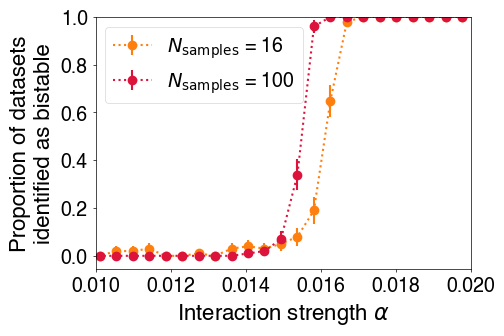

In [104]:
xmin,xmax = 0.01,0.02
plt.figure(figsize=(5,3.25))
for d,Nsamples,color in zip([df,dfLarge],[16,100],['C1','crimson']):
    means = d.dropna().groupby('mu').mean()['landau transition identified']
    bootstrapped_vars = means*(1.-means)/len(means)
    plt.errorbar(means.index,means,yerr=np.sqrt(bootstrapped_vars),
        ls=':',marker='o',label='$N_\mathrm{{samples}}$ = {}'.format(Nsamples),color=color)
    plt.xlabel('Interaction strength $\\alpha$')
    plt.ylabel('Proportion of datasets\nidentified as bistable')
    plt.axis(ymax=1,xmin=xmin,xmax=xmax)
    leg = plt.legend(loc=2,fontsize=14)
    plt.subplots_adjust(bottom=0.175,top=0.95,left=0.2,right=0.95)
makePretty(leg)
plt.savefig('230413_transition_identification_vs_mu.pdf')

## plot main panels of Figure 8

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/369422545.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = d.dropna().groupby('mu').mean()['landau transition identified']
/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/369422545.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = d.dropna().groupby('mu').mean()['landau transition identified']


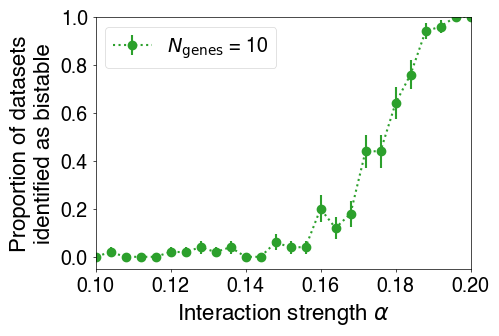

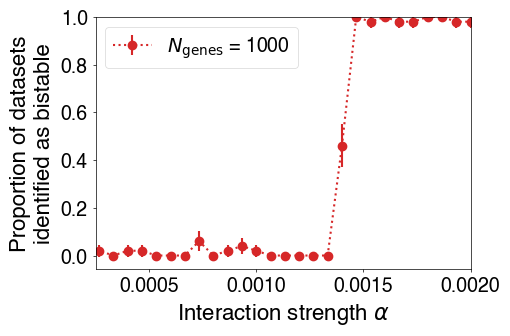

In [109]:
# 2023/4/12 plot for varying Ncomponents
for d,Ncomponents,color,xRange in zip([df10,df1000],[10,1000],['C2','C3'],[(0.1,0.2),(0.00025,0.002)]):
    plt.figure(figsize=(5,3.25))
    means = d.dropna().groupby('mu').mean()['landau transition identified']
    bootstrapped_vars = means*(1.-means)/len(means)
    plt.errorbar(means.index,means,yerr=np.sqrt(bootstrapped_vars),
        ls=':',marker='o',label='$N_\mathrm{{genes}}$ = {}'.format(Ncomponents),color=color)
    plt.xlabel('Interaction strength $\\alpha$')
    plt.ylabel('Proportion of datasets\nidentified as bistable')
    plt.axis(ymax=1,xmin=xRange[0],xmax=xRange[1])
    leg = plt.legend(loc=2,fontsize=14)
    plt.subplots_adjust(bottom=0.175,top=0.95,left=0.2,right=0.95)
    makePretty(leg)
    plt.savefig('230414_transition_identification_vs_mu_Nc{}_Ns16_landau.pdf'.format(Ncomponents))

## plot Figure 4A

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/1556751957.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_landau = d.dropna().groupby('mu').mean()['landau transition identified']
/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_88736/1556751957.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_gmm = d.dropna().groupby('mu').mean()['gaussian PC transition identified']


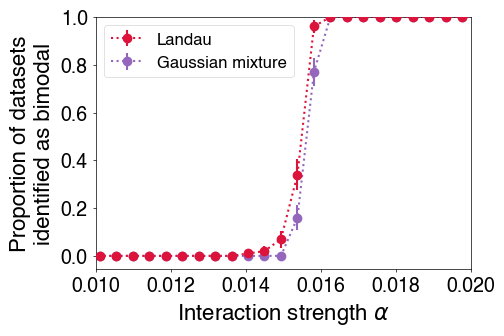

In [73]:
xmin,xmax = 0.01,0.02
for d,Nsamples in zip([dfLarge,],[100,]): #zip([df,dfLarge],[16,100]):
    plt.figure(figsize=(5,3.25))
    means_landau = d.dropna().groupby('mu').mean()['landau transition identified']
    bootstrapped_vars_landau = means_landau*(1.-means_landau)/len(means_landau)
    means_gmm = d.dropna().groupby('mu').mean()['gaussian PC transition identified']
    bootstrapped_vars_gmm = means_gmm*(1.-means_gmm)/len(means_gmm)
    plt.errorbar(means_landau.index,means_landau,yerr=np.sqrt(bootstrapped_vars_landau),
        ls=':',marker='o',label='Landau',color='crimson',zorder=10)
    plt.errorbar(means_gmm.index,means_gmm,yerr=np.sqrt(bootstrapped_vars_gmm),
        ls=':',marker='o',label='Gaussian mixture',color='C4')
    plt.xlabel('Interaction strength $\\alpha$')
    plt.ylabel('Proportion of datasets\nidentified as bimodal')
    plt.axis(ymax=1,xmin=xmin,xmax=xmax)
    leg = plt.legend(loc=2)
    #plt.title('$N_\mathrm{{samples}}$ = {}'.format(Nsamples))
    makePretty(leg=leg)
    plt.subplots_adjust(bottom=0.175,top=0.95,left=0.2,right=0.95)
    plt.savefig('230413_transition_identification_vs_mu_Ns{}_landau_and_gaussian.pdf'.format(Nsamples))

## plot insets of Figure 1

xRange = 12.355984997914307
c = 0.9970058740344461; d = 0.0010000243060883879
mu = 0.01098901098901099; bic diff = 4.610328142407658
Landau transition identified = False
xRange = 25.248003516516082
c = -2.6201365964367294; d = 2.1977851088497897
mu = 0.015824175824175828; bic diff = -31.887440551235137
Landau transition identified = True
xRange = 31.027602792756667
c = -9.65967493383729; d = 8.459449364270363
mu = 0.016703296703296705; bic diff = -117.62799325585057
Landau transition identified = True


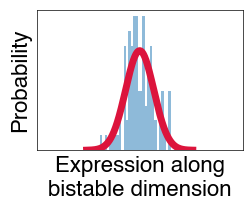

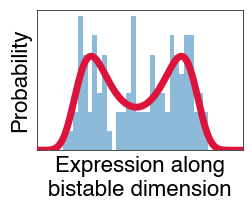

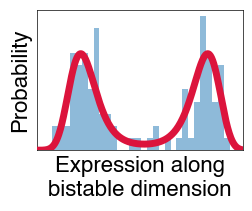

In [55]:
for runIndex,muIndex,mu in zip([6,5,5],[25,36,38],[0.0109,0.0158,0.0167]):
    plotTrue = False
    plt.figure(figsize=(2.75,2.25))
    bistablePlot_fromDataDict(dfLarge,dataDictLarge,runIndex,muIndex,plotGaussian=False,alpha=0.5)
    if plotTrue:
        # also plot landau distribution from fit to 50k samples
        muPlot = np.sort(list(allDataDict.keys()))[muIndex]
        plotLandauTheory_fromDict(landauDataDict[muPlot],color='k',zorder=9,lw=4)
    plt.xlabel('Expression along\nbistable dimension')
    plt.ylabel('Probability')
    plt.axis(xmin=-12,xmax=12)
    plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(bottom=0.3,top=0.925,left=0.175,right=0.925)
    makePretty()
    plt.savefig('220307_landau_bistable_plot_Ns100_Nc91_mu{}.pdf'.format(mu))

## plot insets of Figure 8

In [ ]:
# analogous plots for Ncomponents = 10, 1000

xRange = 7.104585241553242
c = 0.7911781738791213; d = 0.07698536710152605
mu = 0.1; bic diff = 2.7043245390033728
Landau transition identified = False
xRange = 14.339273114739967
c = -4.4420198702372895; d = 3.665604288839745
mu = 0.168; bic diff = -6.814045826168588
Landau transition identified = True
xRange = 17.36665880183493
c = -17.05853007608265; d = 15.08726841879463
mu = 0.2; bic diff = -27.628347077764722
Landau transition identified = True


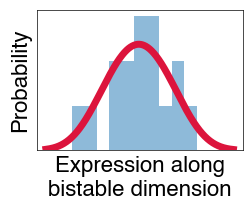

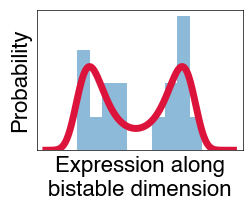

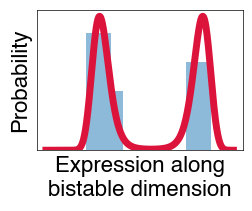

In [108]:
for runIndex,muIndex in zip([5,5,5],[25,42,50]):
    plt.figure(figsize=(2.75,2.25))
    bistablePlot_fromDataDict(df10,dataDict10,runIndex,muIndex,plotGaussian=False,alpha=0.5,bins=10)
    plt.xlabel('Expression along\nbistable dimension')
    plt.ylabel('Probability')
    #plt.axis(xmin=-12,xmax=12)
    plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(bottom=0.3,top=0.925,left=0.175,right=0.925)
    makePretty()
    mu = df10['mu'].unique()[muIndex]
    plt.savefig('230414_landau_bistable_plot_Ns16_Nc10_mu{}.pdf'.format(mu))

xRange = 40.72147736184735
c = 0.997005469102161; d = 0.001000024653381703
mu = 0.0006666666666666668; bic diff = 2.7778188646383835
Landau transition identified = False
xRange = 48.71014698432655
c = -4.436950055987019; d = 3.3909267225946698
mu = 0.0014; bic diff = -6.285396360660037
Landau transition identified = True
xRange = 75.26463824443317
c = -56.29233866675199; d = 51.95959403768677
mu = 0.0014666666666666667; bic diff = -49.74190662595493
Landau transition identified = True


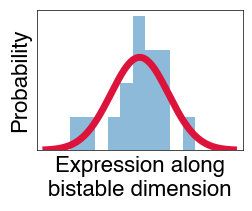

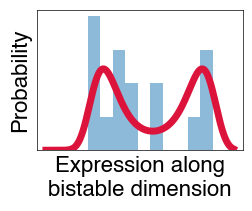

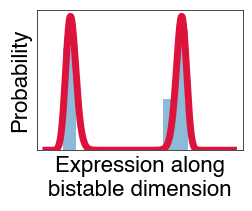

In [107]:
for runIndex,muIndex in zip([5,5,5],[10,21,22]):
    plt.figure(figsize=(2.75,2.25))
    bistablePlot_fromDataDict(df1000,dataDict1000,runIndex,muIndex,
                              plotGaussian=False,alpha=0.5,bins=10)
    plt.xlabel('Expression along\nbistable dimension')
    plt.ylabel('Probability')
    #plt.axis(xmin=-12,xmax=12)
    plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(bottom=0.3,top=0.925,left=0.175,right=0.925)
    makePretty()
    mu = df1000['mu'].unique()[muIndex]
    plt.savefig('230414_landau_bistable_plot_Ns16_Nc1000_mu{}.pdf'.format(mu))

# fit a large amount of simulation data

In [63]:
import glob
from toolbox import load,save

In [65]:
#transformedDataDict = {}
#landauDataDict,gaussianDataDict = {},{}

# load precomputed data
savedDataDict = load('210928_FittingData_Nsamples50000.dat')
transformedDataDict = savedDataDict['transformedDataDict']
landauDataDict = savedDataDict['landauDataDict']
gaussianDataDict = savedDataDict['gaussianDataDict']

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [66]:
# load individual runs that have 1000 samples each
datafilePrefix = 'LandauTestData_allToAll_Ncomponents91_Nsamples1000_Nmus51'
fileList = glob.glob("{}*".format(datafilePrefix))
allDataDict = {}
for file in fileList:
    d = load(file)
    for mu in d:
        if mu in allDataDict:
            allDataDict[mu].append(d[mu]['finalStates'])
        else:
            allDataDict[mu] = [d[mu]['finalStates'],]
# merge into one dataframe per mu
for mu in allDataDict:
    allDataDict[mu] = pd.concat(allDataDict[mu])

In [68]:
# select mu
muIndex = 36 #28
mu = np.sort(list(allDataDict.keys()))[muIndex]

In [69]:
# do naive dimensionality reduction (taken from landauAnalysis.gaussianMixtureAnalysis)
ndims = 1
combinedData = allDataDict[mu]
sampleMean = np.mean(combinedData,axis=0)
vals,vecs = principalComponents(combinedData)
transformedData = np.dot(combinedData-sampleMean,np.transpose(vecs))[:,:ndims]
transformedData = np.real_if_close(transformedData)
transformedDataDict[mu] = transformedData

In [70]:
combinedData.shape, transformedData.shape

((50000, 91), (50000, 1))

Total number of samples = 50000


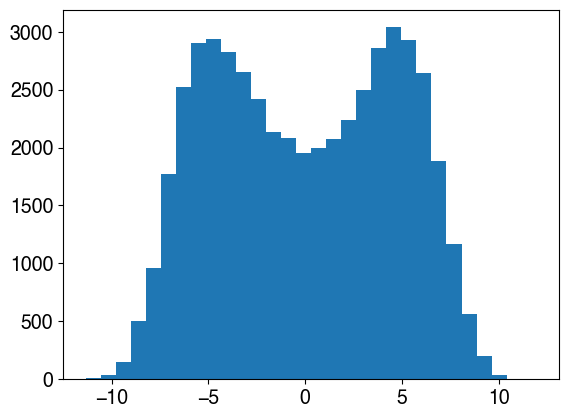

In [71]:
plt.hist(transformedData,bins=30);
print("Total number of samples = {}".format(len(transformedData)))

Total number of samples = 50000


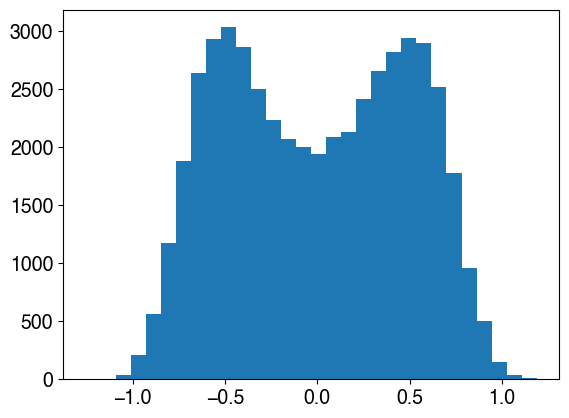

In [72]:
# or directly plot means
projections = combinedData.mean(axis=1)
plt.hist(projections,bins=30);
print("Total number of samples = {}".format(len(combinedData)))

In [14]:
# For some reason mathematica chokes when the mean is zero (by definition here).
# Add 1 to everything to avoid this (doesn't affect anything except the sample mean mu)
# Takes a couple of minutes for 50k samples
landauData = landauAnalysis(transformedData+1.,numNuMax=1)
landauDataDict[mu] = landauData

runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/Dropbox (ASU)/Research/bees/geneExpression/Code/landau/temp_43339.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_43339_LTAoutput.csv


In [15]:
# do Gaussian mixture analysis
gaussianData = gaussianMixtureAnalysis(combinedData,ndims=1)
gaussianDataDict[mu] = gaussianData

In [665]:
resave = False
if resave:
    saveDict = {'gaussianDataDict':gaussianDataDict,
                'landauDataDict':landauDataDict,
                'transformedDataDict':transformedDataDict,}
    save(saveDict,'210928_FittingData_Nsamples50000.dat')

## plot Figure 4B

xRange = 34.95647537991939
mu = 0.015824175824175828
Landau Delta BIC = -11708.575279672685
Gaussian mixture Delta BIC = -10288.220554164436


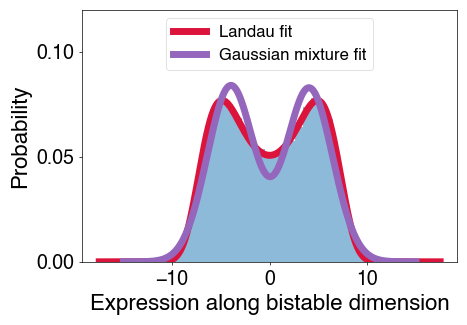

In [67]:
muIndexPlot = 36 #35
muPlot = np.sort(list(allDataDict.keys()))[muIndexPlot]

plt.figure(figsize=(5,3.25))

# plot simulated data histogram and landau fit
bistableIndex = 0
vec = landauDataDict[muPlot]['vecList'][bistableIndex]
Jvals = landauDataDict[muPlot]['valList']
Jvecs = landauDataDict[muPlot]['vecList']
c = landauDataDict[muPlot]['cList'][bistableIndex]
d = landauDataDict[muPlot]['dList'][bistableIndex]
nuMu = landauDataDict[muPlot]['nuMuList'][bistableIndex]
bistablePlot(transformedDataDict[muPlot],vec,Jvals,Jvecs,c,d,nuMu,plotGaussian=False,alpha=0.5)

# plot Gaussian mixture fit
xvals = np.linspace(-15,15,1000)
lls = gaussianDataDict[muPlot]['gMultiple'].score_samples(np.transpose([xvals]))
plt.plot(xvals,np.exp(lls),color='C4',lw=5,zorder=11,label='Gaussian mixture fit')

print("mu = {}".format(muPlot))
print("Landau Delta BIC = {}".format(landauDataDict[muPlot]['bicDiffList'][bistableIndex]))
print("Gaussian mixture Delta BIC = {}".format(gaussianDataDict[muPlot]['bicDiff']))

plt.xlabel('Expression along bistable dimension')

plt.axis(ymax=0.12)
leg = plt.legend(loc=9)
plt.subplots_adjust(bottom=0.175,top=0.95,left=0.2,right=0.95)
plt.yticks([0,0.05,0.1])
makePretty(leg)
plt.savefig('220307_landau_vs_gaussian_Ns50000_mu0.0158.pdf')

## 2023/4/6 do KS test to quantify how much better Landau fits than Gaussian mixture

In [17]:
import scipy.stats

In [69]:
def LandauTransitionDistributionRelativePDF_fromDict(xVal,landauAnalysis,bistableIndex=0):
    vec = landauAnalysis['vecList'][bistableIndex]
    Jvals = landauAnalysis['valList']
    Jvecs = landauAnalysis['vecList']
    c = landauAnalysis['cList'][bistableIndex]
    d = landauAnalysis['dList'][bistableIndex]
    nuMu = landauAnalysis['nuMuList'][bistableIndex]
    
    return np.exp(LandauTransitionDistributionRelativeLogPDF(
                        xVal*vec,   
                        nuMu*vec,
                        Jvals,
                        Jvecs,
                        vec,
                        c,
                        d))

In [88]:
sim_data = transformedDataDict[muPlot].reshape(len(transformedDataDict[muPlot]))

# we will create CDFs numerically by evaluating them at a large set of points and interpolating

# compute Gaussian mixture cdf
GMM_lls = gaussianDataDict[muPlot]['gMultiple'].score_samples(np.transpose([xvals]))
GMM_prob_density = np.exp(GMM_lls)
GMM_cdf_points = np.cumsum(GMM_prob_density) / np.sum(GMM_prob_density)
GMM_cdf = lambda x: np.interp(x,xvals,GMM_cdf_points)

# compute Landau cdf
landau_unnormed_prob_density = \
    [ LandauTransitionDistributionRelativePDF_fromDict(xval,landauDataDict[muPlot]) for xval in xvals ]
landau_prob_density = landau_unnormed_prob_density / (np.sum(landau_unnormed_prob_density)*(np.diff(xvals)[0]))
landau_cdf_points = np.cumsum(landau_prob_density) / np.sum(landau_prob_density)
landau_cdf = lambda x: np.interp(x,xvals,landau_cdf_points)

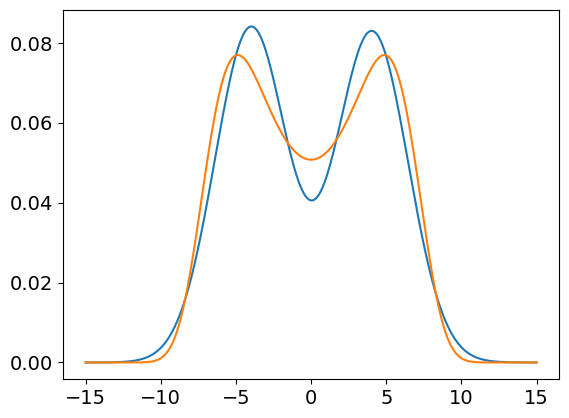

In [89]:
# sanity check plot 1
plt.plot(xvals,GMM_prob_density)
plt.plot(xvals,landau_prob_density)

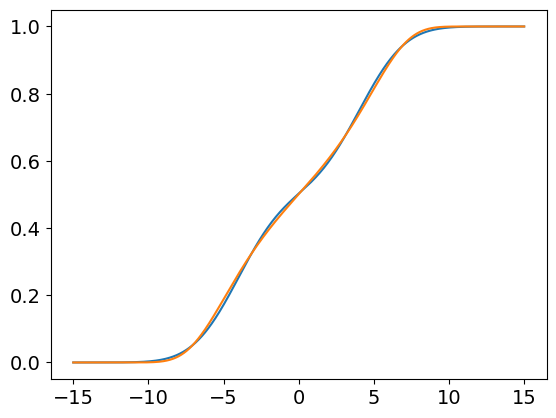

In [90]:
# sanity check plot 2
plt.plot(xvals,GMM_cdf_points)
plt.plot(xvals,landau_cdf_points)

In [91]:
scipy.stats.kstest(sim_data,GMM_cdf)

KstestResult(statistic=0.016727164619572132, pvalue=1.3931907978880335e-12, statistic_location=4.5692574348875885, statistic_sign=-1)

In [92]:
scipy.stats.kstest(sim_data,landau_cdf)

KstestResult(statistic=0.004232430538010701, pvalue=0.3310034721406724, statistic_location=3.3364468626836183, statistic_sign=-1)